In [14]:
import os
import sys
home_dir = "../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import subprocess
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import utility.pickle_utils as pickle_utils

#### Plotting seq_region, epbd_feat and cross_attn_weights

In [15]:
# the following two are best and worst case according to dnabert2epbdVSdnabert2_percent and dnabert2epbdVSdnabert2_relative by auroc metric
# best case: wgEncodeAwgTfbsSydhHepg2Mafksc477IggrabUniPk
# worst case: wgEncodeAwgTfbsSydhHelas3Bdp1UniPk
# good case: wgEncodeAwgTfbsUtaA549CtcfUniPk
# bad case: wgEncodeAwgTfbsSydhHelas3Znf274UcdUniPk

label="wgEncodeAwgTfbsUtaA549CtcfUniPk" # wgEncodeAwgTfbsUtaA549CtcfUniPk, wgEncodeAwgTfbsBroadGm12878Ezh239875UniPk
out_plots_dir = home_dir+f"analysis/figures/epbd_vs_crossattn_overlaying_plots/{label}/"
os.makedirs(out_plots_dir, exist_ok=True)

In [16]:
crossattn_weights_list = pickle_utils.load(home_dir+f"analysis/weights/690_label_specific/{label}_crossattn_weights_list.pkl")
print(len(crossattn_weights_list))

data_df = pd.read_csv(home_dir+"data/train_val_test/peaks_with_labels_test.tsv.gz", compression="gzip", sep="\t")
data_df = data_df[data_df["labels"].apply(lambda x: label in x)]
data_df.reset_index(drop=True, inplace=True)
data_df.drop(columns=["n_labels", "labels"], inplace=True)
data_df.to_csv(home_dir+"analysis/temp/x.sorted", index=False, header=False, sep="\t")
print(data_df.shape)

4797
(4797, 3)


In [17]:
cmd = f"../bedtools/bedtools intersect -a temp/x.sorted -b ../data/processed/wgEncodeAwgTfbsUniform_sorted/{label}.narrowPeak.sorted.gz -wo -f .5 -sorted > temp/x.bindingregions.sorted"
subprocess.call(cmd, shell=True)

0

In [18]:
col_names = ["genomeChrom", "genomeChromStart", "genomeChromEnd", "chrom", "chromStart", "chromEnd", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak", "intersectedBps"] 
data_with_bindingregions_df = pd.read_csv(home_dir+"analysis/temp/x.bindingregions.sorted", sep="\t", names=col_names)
data_with_bindingregions_df.shape
data_with_bindingregions_df.drop_duplicates(subset=["genomeChrom", "genomeChromStart", "genomeChromEnd"], keep="first", ignore_index=True, inplace=True) # # dropping chromosomal coordinate duplicates with overlapping, because some may have multiple overlapping
data_with_bindingregions_df.shape

(4797, 14)

In [19]:
seq_dict = pickle_utils.load(home_dir+"data/processed/seq_with_flanks_dict.pkl")

In [20]:
def get_epbd_features(fname):
    fpath = home_dir+"data/pydnaepbd_things/features/id_seqs/"+fname
    data = pickle_utils.load(fpath)
    
    # coord and flip features
    coord = np.expand_dims(data["coord"], axis=0)
    flips = np.transpose(data["flip_verbose"])
    epbd_features = np.concatenate([coord, flips], axis=0) / 80000
    epbd_features = torch.tensor(epbd_features, dtype=torch.float32)
    # print(epbd_features.shape) # [6, 200]
    return epbd_features

In [21]:
# conved_epbd_features_list = pickle_utils.load(home_dir+f"analysis/conved_epbd_features_list/{label}.pkl")
# def get_conved_epbd_features(i):
#     return conved_epbd_features_list[i] #np array of  suze 200

# # get_conved_epbd_features(0)

In [22]:
from utility.dnabert2 import get_dnabert2_tokenizer
tokenizer = get_dnabert2_tokenizer(max_num_tokens=512, home_dir=home_dir)
# print(tokenizer)
def get_start_end(seq):
    toked = tokenizer(
                seq,
                return_tensors="pt",
                padding="longest",
                max_length=512,
                truncation=True,
            )
    # print(toked["input_ids"][0])
    toked_seq_list= tokenizer.decode(toked["input_ids"][0]).split()
    cum_len = 0
    start_token_no, end_token_no = -1, -1
    start_nuc_pos_in_token, end_nuc_pos_in_token = -1, -1
    s = [] # this will store the middle 200 nuc based as toked
    for i in range(1, len(toked_seq_list)-1): # 1st is the cls token
        # print(toked_seq_list[i])
        cum_len += len(toked_seq_list[i])
        
        if cum_len>=400 and cum_len<=599:
            # print(i, cum_len, toked_seq_list[i])
            if start_token_no==-1: 
                start_token_no = i
                start_nuc_pos_in_token =  len(toked_seq_list[i]) - (cum_len - 400)
                s.append(toked_seq_list[i][start_nuc_pos_in_token:])
                # print(start_nuc_pos_in_token, toked_seq_list[i], "".join(s))
                # break
            
            else:
                s.append(toked_seq_list[i])
            # break
        
        elif cum_len>=600:
            end_token_no = i+1
            end_nuc_pos_in_token = len(toked_seq_list[i]) - (cum_len - 600)
            s.append(toked_seq_list[i][:end_nuc_pos_in_token])
            # print(i, cum_len, toked_seq_list[i], toked_seq_list[i][:end_nuc_pos_in_token], len("".join(s)))
            break
      
    
    print(start_token_no, start_nuc_pos_in_token, end_token_no, end_nuc_pos_in_token, len("".join(s)), len(s), end_token_no-start_token_no)
    return start_token_no, start_nuc_pos_in_token, end_token_no, end_nuc_pos_in_token, s

# seq = "GGAATGGCTCATGGGCCTTTACCTCCTCTGAGTGGTTTTTCTCCTGACAGGGGACACTTTGCATTGATCCCTGAAGCAGTTCCACTCCTCAAGGCAGCCTTCTGTGGCTCCCTGGACTGTGCTCCTTCAGAGGAAGACCTCCAGACCTCAGCTTCTTCCTGTATGACATGAGGGAGGCTGGCATTTATACACTCATTAAAAATTCATATTTTAAAGCATTTTCCAGCAAATCCACCCCCAGAAGAGAACAATTTTTCTGCGTCTCCCGAACCAATTATTCAATAGTGCGCTGTGATACCCACCCAGCGCAGGCTGGAGACAAGATGGGGTGTGGACTCTCGGGAGGCGGCGACTCCAGGCGTCCACCAGAGCGGGGCTTACGGTCCCCGAGGCGGCGCGGCTGAAGAGTTGGTTTAGGTTTAATGAGAAACAACTTGGCAAATCTGAAAAACAATAGTTGGGAAAAGTGTTAAAAAAGACCAAGCCCAGGAGCTTAAGACAAAATCTGGCAGTTCCCTCCCGCGGCCGCCAGGGGTCAGTGCGCACCTGAGGAGGGGGAGGCCCGGGATCGGCGAGCGCCTGAGGAGGGAGGGTCCGGGGGTCACTGCGCACCTGCGGAGGTGGGGGCGGCCAGGGTCAGTGTCCCCCTGGGGAGGGGGGGTCAGGGGGTCAGCCTTCACCTGAGGAGGGGGCGGCCAGGGTCCGTGCCCACCTGAGGAGGGGGGTTCAGGGGGTCAGCCTTCACCTGCGGAGGTGGGGGCGGCCAGGGTCAGTGTCCACCTGGGGGGGGGTTAGGGGGTCAGCCTTCACCTGCGGAGGTGGGGGCGGCCAGGGTCAGTGTCCACCTGGGGGGGGGTCAGGGGGTCAGCCTTCACCTGAGGAGGTGGGGGCAGCCAGGGTCCGTGTCCACCTGGGGGGGGGTCAGGGGGTCAGCCTTCACCTGAGGAGGGGGCGGCCGGCGGTCAGTGCGCACCTGAAGAGGGGGAGGCCCGGGGTCAGG"
# i, j,k, l, x = get_start_end(seq)

In [23]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

73 6 112 3 200 39 39
torch.Size([6, 200]) (200,)
-0.45063780574566414 2.1450961604527518e-11 -0.6057201231665307 2.056310018387151e-21
83 2 126 4 200 43 43
torch.Size([6, 200]) (200,)
-0.5824682660170387 1.4658195189821448e-19 -0.6141923706309418 3.9767132389856045e-22
80 6 119 4 200 39 39
torch.Size([6, 200]) (200,)
-0.4483599965319617 2.778975606603125e-11 -0.6333320498631422 8.047096932474764e-24
79 3 121 4 200 42 42
torch.Size([6, 200]) (200,)
-0.6293736768148676 1.8434821732334806e-23 -0.62862339041463 2.1542291141884762e-23
81 4 122 2 200 41 41
torch.Size([6, 200]) (200,)
-0.3974309731579406 5.6400098505489925e-09 -0.47669246355155476 9.646756898061418e-13
78 6 119 5 200 41 41
torch.Size([6, 200]) (200,)
-0.05255292393415132 0.45986874130117233 -0.04622409842927209 0.5157196494313887
78 5 120 4 200 42 42
torch.Size([6, 200]) (200,)
-0.26315095375424524 0.00016670827148931224 0.004648736002793895 0.9479102005961889
83 1 124 4 200 41 41
torch.Size([6, 200]) (200,)
-0.25623901616299

79 3 121 1 200 42 42
torch.Size([6, 200]) (200,)
-0.4438088463358542 4.6351206937336777e-11 -0.42139435606418263 5.169646885688731e-10
76 2 118 1 200 42 42
torch.Size([6, 200]) (200,)
-0.137852524073742 0.05158114206770013 -0.2993232906258388 1.6648199261609133e-05
77 4 118 1 200 41 41
torch.Size([6, 200]) (200,)
-0.40235120663412366 3.5061872998831217e-09 -0.47922663764293905 7.033618784339419e-13
81 2 123 7 200 42 42
torch.Size([6, 200]) (200,)
-0.40632125712972395 2.375694513283159e-09 -0.46915587192351016 2.4311587693777e-12
77 6 119 4 200 42 42
torch.Size([6, 200]) (200,)
-0.5930112627975237 2.2100525869943672e-20 -0.6935028975128545 5.1965746744045845e-30
79 1 125 3 200 46 46
torch.Size([6, 200]) (200,)
-0.5243375014801817 1.6051724166400873e-15 -0.543159614120793 9.603869604714506e-17
81 1 122 6 200 41 41
torch.Size([6, 200]) (200,)
-0.6176802956119255 1.9927900921158537e-22 -0.5882665763605476 5.222587184273231e-20
83 4 127 2 200 44 44
torch.Size([6, 200]) (200,)
0.342342961810

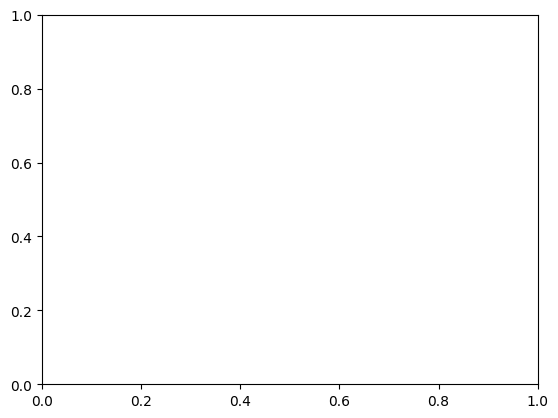

In [24]:
from scipy.interpolate import interp1d, make_interp_spline
from scipy.stats import pearsonr, spearmanr

avg_crossattn_w = []
pearson_corrs, spearmanr_corrs = [], []
for i in range(data_with_bindingregions_df.shape[0]):
    plt.cla()
    x = data_with_bindingregions_df.loc[i]
    chrom, start, end = x["genomeChrom"], int(x["genomeChromStart"]), int(x["genomeChromEnd"])
    seq_id = f"{chrom}_{str(start)}_{str(end)}"
    seq = seq_dict[seq_id]
    # print(seq)
    
    # putting the binding regions into the genone regions (200 bps)
    abs_reg_start =  int(x["genomeChromStart"])  if int(x["chromStart"]) < int(x["genomeChromStart"]) else int(x["chromStart"])
    abs_reg_end = int(x["genomeChromEnd"]) if int(x["chromEnd"]) > int(x["genomeChromEnd"]) else int(x["chromEnd"])
    # print(abs_reg_start, abs_reg_end, abs_reg_end-abs_reg_start)
    
    # putting into string abs position
    abs_reg_start = abs_reg_start - int(x["genomeChromStart"])
    abs_reg_end = abs_reg_end - int(x["genomeChromStart"])
    # print(abs_reg_start, abs_reg_end, abs_reg_end-abs_reg_start)
    
    
    # plotting raw epbd features
    epbd_features = get_epbd_features(f"{seq_id}.pkl")
    # print(cross_attn_w.shape, epbd_features.shape)
    data1 = np.array(epbd_features[4])
    data1 = normalize_data(data1)
    # plt.plot(range(epbd_features.shape[1]), data1, label="EPBD-features (flip)")
    # plt.show()
    
    
    
    # print(tok_start, tok_end, toked_seq[tok_start:tok_end])
    cross_attn_w = crossattn_weights_list[i]
    # print(np.mean(cross_attn_w, axis=0, keepdims=True).shape)
    avg_crossattn_w.append(torch.tensor(np.mean(cross_attn_w, axis=0)))
    temp_avg_crossattn_w = np.mean(cross_attn_w, axis=0)
    # print(temp_avg_crossattn_w.shape)
    
    start_token_no, start_nuc_pos_in_token, end_token_no, end_nuc_pos_in_token, toked_seq = get_start_end(seq)
    x = []
    for k, j in enumerate(range(start_token_no, end_token_no)):
        # print(toked_seq[i])
        for b in toked_seq[k]:
            x.append(temp_avg_crossattn_w[j])
        # break
    # print(len(x))
    data2 = normalize_data(np.array(x))
    # print(data2.shape)
    # plt.plot(range(data2.shape[0]), data2, label="Cross-attention weights")

    # this saves the epbd_features and avg_crossattn of the i-th item
    # os.makedirs(home_dir+f"analysis/crossattn_and_epbdfeats_pairs/{label}/", exist_ok=True)
    # pickle_utils.save(epbd_features, home_dir+f"analysis/crossattn_and_epbdfeats_pairs/{label}/{i}_epbdfeats.pkl")
    # pickle_utils.save(data2, home_dir+f"analysis/crossattn_and_epbdfeats_pairs/{label}/{i}_avg_crossattn.pkl")
    # print(epbd_features.shape, data2.shape)
    
    
    # data3 = normalize_data(get_conved_epbd_features(i))
    # plt.plot(range(data3.shape[0]), data3, label="EPBD-features (conv)")
    
    pearson_corr, p_pvalue = pearsonr(data1, data2)
    spearmanr_corr, s_pvalue = spearmanr(data1, data2)
    print(pearson_corr, p_pvalue, spearmanr_corr, s_pvalue)
    
    
    # # plotting smoother version of the above data
    # x = np.array(range(data2.shape[0]))
    # y = np.copy(data2)
    # interpolated_points = interp1d(x, y, kind = "cubic") # or the following line
    # # interpolated_points = make_interp_spline(x, y)
    # X2_=np.linspace(x.min(), x.max(), 30)
    # Y2_=interpolated_points(X2_)
    # plt.plot(X2_, Y2_, label="Cross-attention weights (smooth)")
    
    # x = np.array(range(data1.shape[0]))
    # y = np.copy(data1)
    # interpolated_points = interp1d(x, y, kind = "cubic") # or the following line
    # # interpolated_points = make_interp_spline(x, y)
    # X1_=np.linspace(x.min(), x.max(), 30)
    # Y1_=interpolated_points(X1_)
    # plt.plot(X1_, Y1_, label="EPBD-features (flip)")
    
    # pearson_corr, p_pvalue = pearsonr(Y1_, Y2_)
    # spearmanr_corr, s_pvalue = spearmanr(Y1_, Y2_)
    # print(pearson_corr, p_pvalue, spearmanr_corr, s_pvalue)
    
    
    # plt.legend()
    # plt.savefig(out_plots_dir+f"{i}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=.05)
    # plt.show()
    
    pearson_corrs.append(pearson_corr), spearmanr_corrs.append(spearmanr_corr)
    if i+1==10: break
    # break


print(np.array(pearson_corrs).mean(), np.array(spearmanr_corrs).mean())
print(np.median(np.array(pearson_corrs)), np.median(np.array(spearmanr_corrs)))